In [1]:
# Specification
# https://github.com/SBRG/bigg_models/wiki/BiGG-Models-ID-Specification-and-Guidelines

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import json

In [3]:
with open('../data/iND750.json', 'r') as file:
    models = json.loads(file.read())

## Data Inspection

In [4]:
type(models)

dict

In [5]:
len(models)

6

In [6]:
models.keys()

dict_keys(['metabolites', 'reactions', 'genes', 'id', 'compartments', 'version'])

In [7]:
models['id']

'iND750'

In [8]:
models['version']

'1'

In [9]:
models['compartments']

{'c': 'cytosol',
 'e': 'extracellular space',
 'g': 'golgi apparatus',
 'm': 'mitochondria',
 'n': 'nucleus',
 'r': 'endoplasmic reticulum',
 'v': 'vacuole',
 'x': 'peroxisome/glyoxysome'}

In [10]:
models['reactions'][:2]

[{'id': 'EX_met__L_e',
  'name': 'L-Methionine exchange',
  'metabolites': {'met__L_e': -1.0},
  'lower_bound': 0.0,
  'upper_bound': 999999.0,
  'gene_reaction_rule': '',
  'subsystem': 'Extracellular exchange',
  'notes': {'original_bigg_ids': ['EX_met_L_LPAREN_e_RPAREN_']},
  'annotation': {'bigg.reaction': ['EX_met__L_e'],
   'metanetx.reaction': ['MNXR101493'],
   'sabiork': ['13469', '13461'],
   'sbo': 'SBO:0000627',
   'seed.reaction': ['rxn08920', 'rxn10976']}},
 {'id': 'EX_mmet_e',
  'name': 'S-Methyl-L-methionine exchange',
  'metabolites': {'mmet_e': -1.0},
  'lower_bound': 0.0,
  'upper_bound': 999999.0,
  'gene_reaction_rule': '',
  'subsystem': 'Extracellular exchange',
  'notes': {'original_bigg_ids': ['EX_mmet_LPAREN_e_RPAREN_']},
  'annotation': {'bigg.reaction': ['EX_mmet_e'],
   'biocyc': ['META:TRANS-RXN0-486'],
   'metanetx.reaction': ['MNXR101659'],
   'sbo': 'SBO:0000627',
   'seed.reaction': ['rxn08945']}}]

In [11]:
models['metabolites'][:2]

[{'id': 'ala__L_e',
  'name': 'L-Alanine',
  'compartment': 'e',
  'formula': 'C3H7NO2',
  'notes': {'original_bigg_ids': ['ala_DASH_L_e']},
  'annotation': {'bigg.metabolite': ['ala__L'],
   'biocyc': ['META:L-ALPHA-ALANINE'],
   'chebi': ['CHEBI:21216',
    'CHEBI:32440',
    'CHEBI:2539',
    'CHEBI:46308',
    'CHEBI:40735',
    'CHEBI:16977',
    'CHEBI:22277',
    'CHEBI:32439',
    'CHEBI:57972',
    'CHEBI:6171',
    'CHEBI:16449',
    'CHEBI:32431',
    'CHEBI:32432',
    'CHEBI:66916',
    'CHEBI:40734',
    'CHEBI:13069',
    'CHEBI:76050',
    'CHEBI:13748'],
   'envipath': ['650babc9-9d68-4b73-9332-11972ca26f7b/compound/d80739c7-acbe-4c00-8ea2-e3d19a191be2',
    '650babc9-9d68-4b73-9332-11972ca26f7b/compound/1aad160f-1c5e-48e0-9473-6305321b31ed'],
   'hmdb': ['HMDB00161', 'HMDB62251'],
   'inchi_key': ['QNAYBMKLOCPYGJ-REOHCLBHSA-N'],
   'kegg.compound': ['C01401', 'C00041'],
   'kegg.drug': ['D00012'],
   'metanetx.chemical': ['MNXM32'],
   'reactome.compound': ['389664', 

## 'gene reaction rule' in 'reactions'

In [12]:
for i, reaction in enumerate(models['reactions']):
    if i < 60:
        print(reaction['gene_reaction_rule'])
    else:
        break
        


















































YKL182W and YPL231W


YKL182W and YPL231W

YKL188C and YPL147W

YKL182W and YPL231W

YKL188C and YPL147W



From above, we see that some reactions are ruled by some genes, and some reactions are not ruled by any gene.

## look at a spefic reaction and compare data to its web infomation

In [13]:
# http://bigg.ucsd.edu/models/iND750/reactions/13BGH
for reaction in models['reactions']:
    if reaction['id'] == '13BGH':
        print(reaction)

{'id': '13BGH', 'name': 'Endo 1 3 beta glucan glucohydrase', 'metabolites': {'13BDglcn_c': -1.0, 'glc__D_c': 1.0, 'h2o_c': -1.0}, 'lower_bound': 0.0, 'upper_bound': 999999.0, 'gene_reaction_rule': 'YGR282C', 'subsystem': 'Starch and Sucrose Metabolism', 'notes': {'original_bigg_ids': ['13BGH']}, 'annotation': {'bigg.reaction': ['13BGH'], 'metanetx.reaction': ['MNXR94686'], 'sbo': 'SBO:0000176'}}


The useful attribute here is *'metabolites'*, 

In [14]:
for gene in models['genes']:
    if gene['id'] == 'YGR282C':
        print(gene)

{'id': 'YGR282C', 'name': 'BGL2', 'notes': {'original_bigg_ids': ['YGR282C']}, 'annotation': {'ncbigene': ['853199'], 'refseq_locus_tag': ['YGR282C'], 'refseq_name': ['BGL2'], 'refseq_synonym': ['SCW9'], 'sbo': 'SBO:0000243', 'sgd': ['S000003514']}}


## Data Preparation

In [15]:
# step 1: find one gene
# step 2: find the reactions which are ruled by this gene
# step 3: find the substrate (< 0) and products (> 0) of one of these reactions. Repeat for all reactions ruled by this gene.
# step 4: repeat above steps for all genes -- every gene has a list of substrates and products.
# step 5: if a product of gene A is a substrate of gene B, then gene A and gene B has a connection

In [16]:
genes = {}
inorganics = []
for gene in models['genes']:
    genes[gene['id']] = {}
    genes[gene['id']]['reactions'] = []
    genes[gene['id']]['substrates'] = []
    genes[gene['id']]['products'] = []
    for reaction in models['reactions']:
        if gene['id'] in reaction['gene_reaction_rule'] and gene['id'] not in genes[gene['id']]['reactions']:
            genes[gene['id']]['reactions'].append(reaction['id'])
            for metabolite, v in reaction['metabolites'].items():
                for m in models['metabolites']:
                    if m['id'] == metabolite:
                        # exclude inorganic metabolites
                        if 'C' in m['formula'] and m['formula'] not in ['CO2', 'CO', 'C']:
                            if v > 0 and metabolite not in genes[gene['id']]['products']:
                                genes[gene['id']]['products'].append(metabolite)
                            if v < 0 and metabolite not in genes[gene['id']]['substrates']:
                                genes[gene['id']]['substrates'].append(metabolite)
                        elif metabolite not in inorganics:
                            inorganics.append(metabolite)
                        else:
                            break
#                     if v == 1 and metabolite not in genes[gene['id']]['products']:
#                         genes[gene['id']]['products'].append(metabolite)
#                     if v == -1 and metabolite not in genes[gene['id']]['substrates']:
#                         genes[gene['id']]['substrates'].append(metabolite)
                            
for k0, v0 in genes.items():
    v0['links'] = []
    for product in v0['products']:
        for k1, v1 in genes.items():
            if k1 != k0 and product in v1['substrates']:
                v0['links'].append(k1)
                

In [17]:
inorganics

['co2_m',
 'h2o_m',
 'h_m',
 'o2_m',
 'h2o_c',
 'h_c',
 'co2_c',
 'h2o_x',
 'h_x',
 'pi_x',
 'h2o_e',
 'pi_e',
 'o2_c',
 'pi_m',
 'ppi_c',
 'nh4_c',
 'ppi_m',
 'ppi_x',
 'h_e',
 'pi_c',
 'h2o2_x',
 'o2_x',
 'trnaglu_c',
 'trnaglu_m',
 'trnaarg_c',
 'trnaarg_m',
 'trnagly_c',
 'nh4_e',
 'h2o2_c',
 'h2s_c',
 'h_n',
 'pi_n',
 'h2o_n',
 'nh4_x',
 'trnacys_c',
 'trnaasp_c',
 'trnaasp_m',
 'so4_c',
 'trnahis_c',
 'trnahis_m',
 'nh4_m',
 'lpro_m',
 'dhlpro_m',
 'h_r',
 'trnaala_c',
 'co2_x',
 'h2o_g',
 'h_g',
 'pi_g',
 'h2o_v',
 'h_v',
 'pi_v',
 'trnaile_c',
 'trnaile_m',
 's_c',
 'trnaleu_c',
 'fe2_m',
 'trnaleu_m',
 'trnalys_c',
 'trnalys_m',
 'trnamet_c',
 'trnamet_m',
 'trnaphe_c',
 'trnaphe_m',
 'oh1_c',
 'oh1_m',
 'na1_c',
 'na1_e',
 'trnagln_c',
 'trnapro_c',
 'co2_g',
 'co2_v',
 'trdox_c',
 'trdrd_c',
 'trdox_n',
 'trdrd_n',
 'so3_c',
 'trnaser_c',
 'so4_e',
 'h2o_r',
 'o2_r',
 'trnathr_c',
 'trnathr_m',
 'trdox_m',
 'trdrd_m',
 'trnatrp_c',
 'trnatrp_m',
 'trnatyr_c',
 'trnatyr_m',
 

In [18]:
df = pd.DataFrame.from_dict(genes).T
df

,reactions,substrates,products,links
YER061C,"[ACOATAm, FAS100ACPm, FAS120ACPm, FAS140ACPm, ...","[ACP_m, accoa_m, malACP_m, nadph_m, ocACP_m, d...","[acACP_m, coa_m, ACP_m, dcaACP_m, nadp_m, ddca...","[YOR221C, YKL055C, YKL192C, YPL148C, YAR035W, ..."
YLR304C,"[ACONT, ACONTm]","[cit_c, cit_m]","[icit_c, icit_m]","[YLR174W, YER065C, YBR291C, YOR136W, YNL037C, ..."
YPL231W,"[FA120ACPHi, FA140ACPHi, FA141ACPHi, FA160ACPH...","[ddcaACP_c, myrsACP_c, tdeACP_c, palmACP_c, hd...","[ACP_c, ddca_c, ttdca_c, ttdcea_c, hdca_c, hdc...","[YKL182W, YKL182W, YNR016C, YGR037C, YKL182W, ..."
YBR023C,[CHTNS],[udpacgal_c],"[chitin_c, udp_c]","[YLR307W, YLR308W, YKL067W, YER070W, YJL026W]"
YJL200C,[ACONTm],[cit_m],[icit_m],"[YBR291C, YOR136W, YNL037C, YDL066W]"
...,...,...,...,...
YDR322C_A,[ATPS3m],[adp_m],[atp_m],"[YER069W, YAL054C, YER170W, YOL033W, YHR091C, ..."
YOL077W_A,[ATPS3m],[adp_m],[atp_m],"[YER069W, YAL054C, YER170W, YOL033W, YHR091C, ..."
YML081C_A,[ATPS3m],[adp_m],[atp_m],"[YER069W, YAL054C, YER170W, YOL033W, YHR091C, ..."
YHR001W_A,[CYOR_u6m],"[ficytc_m, q6h2_m]","[focytc_m, q6_m]","[YHR051W, YMR256C, Q0250, YGL187C, YDL067C, YG..."


In [19]:
df1 = pd.DataFrame({'index':df.index.repeat(df.links.str.len()), 'links':df.links.sum()})
df1

,index,links
0,YER061C,YOR221C
1,YER061C,YKL055C
2,YER061C,YKL192C
3,YER061C,YPL148C
4,YER061C,YAR035W
...,...,...
8921,YHR001W_A,YMR118C
8922,YHR001W_A,YJL045W
8923,YHR001W_A,YDR178W
8924,YCR073W_A,YGR256W


In [20]:
# show genes having no links
print(df.loc[df['links'].str.len() == 0])

                  reactions              substrates            products links
YDL142C         [CLPNSm_SC]  [cdpdag_SC_m, pg_SC_m]  [clpn_SC_m, cmp_m]    []
YAR071W             [ACP1e]                 [fmn_e]          [ribflv_e]    []
YDR044W            [CPPPGO]              [cpppg3_c]           [pppg9_c]    []
YBR132C              [CRNt]                 [crn_e]             [crn_c]    []
YPL148C             [ACPSm]                 [coa_m]    [pan4p_m, pap_m]    []
...                     ...                     ...                 ...   ...
YPL212C             [YUMPS]          [r5p_c, ura_c]           [psd5p_c]    []
YNL292W             [YUMPS]          [r5p_c, ura_c]           [psd5p_c]    []
YGL063W             [YUMPS]          [r5p_c, ura_c]           [psd5p_c]    []
YFL001W             [YUMPS]          [r5p_c, ura_c]           [psd5p_c]    []
YHR039C_A  [ATPS3g, ATPS3v]          [adp_g, adp_v]      [atp_g, atp_v]    []

[85 rows x 4 columns]


In [21]:
G = nx.from_pandas_edgelist(df=df1, source='index', target='links')

In [22]:
# get subgraphs
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [23]:
giant = max(connected_component_subgraphs(G), key=len)

In [24]:
giant.number_of_nodes()

684

## Laplacian and Eigen

In [25]:
# Laplacian Matrix
L = nx.laplacian_matrix(giant, nodelist=sorted(giant.nodes()))
L.todense()

matrix([[12,  0,  0, ...,  0,  0, -1],
        [ 0, 30,  0, ...,  0,  0,  0],
        [ 0,  0, 30, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  3,  0,  0],
        [ 0,  0,  0, ...,  0, 12,  0],
        [-1,  0,  0, ...,  0,  0, 26]], dtype=int32)

In [26]:
eig = np.linalg.eig(L.todense())
eig

(array([ 1.51058453e+02+0.00000000e+00j,  1.39744082e+02+0.00000000e+00j,
         1.38000000e+02+0.00000000e+00j,  1.47000000e+02+0.00000000e+00j,
         1.47000000e+02+0.00000000e+00j,  9.93919628e+01+0.00000000e+00j,
         9.64248008e+01+0.00000000e+00j,  9.32659273e+01+0.00000000e+00j,
         8.53306905e+01+0.00000000e+00j,  8.24209822e+01+0.00000000e+00j,
         8.15589779e+01+0.00000000e+00j,  7.96571079e+01+0.00000000e+00j,
         7.48742895e+01+0.00000000e+00j,  7.09399596e+01+0.00000000e+00j,
         6.93973882e+01+0.00000000e+00j,  6.81754466e+01+0.00000000e+00j,
         6.74557535e+01+0.00000000e+00j,  6.58479230e+01+0.00000000e+00j,
         6.80000000e+01+0.00000000e+00j,  6.36404772e+01+0.00000000e+00j,
         6.20168209e+01+0.00000000e+00j,  6.04402857e+01+0.00000000e+00j,
         6.40000000e+01+0.00000000e+00j,  6.40000000e+01+0.00000000e+00j,
         5.81964159e+01+0.00000000e+00j,  5.68843862e+01+0.00000000e+00j,
         5.90000000e+01+0.00000000e+00

## Plotting

In [27]:
def draw_sub(k, eig, G, layout, ccmap, vmin, vmax):
    i = np.argpartition(eig[0], k)[k]
    v = eig[1].real[:, i].T.tolist()[0]
    # node_color is the coefficient of eigenvectors 
    nx.draw(G, layout, node_size=100, node_color=v, edge_color="#cccccc", edgecolors='#000000', cmap=ccmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    sm = plt.cm.ScalarMappable(cmap=ccmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm)
    plt.title('k = {}'.format(k))

In [28]:
def change_scale(eig):
    # smallest coefficient
    vmin = np.amin(eig[1])
    # largest coefficient
    vmax = np.amax(eig[1])
    if vmin*vmax < 0:
        v = max(abs(vmin), abs(vmax))
        vmin = -v
        vmax = v
    # if vmin and vmax have the same sign, the colorbar can't be symmetrical.
    return vmin, vmax

## Make Color Map

In [29]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
winter = cm.get_cmap('winter', 128)
autumn = cm.get_cmap('autumn_r', 128)

newcolors = np.vstack((winter(np.linspace(0, 1, 128)),
                       autumn(np.linspace(0, 1, 128))))
ccmap = ListedColormap(newcolors, name='OrangeBlue')

In [30]:
plt.rc('figure', figsize=(30, 30))
K = 5/np.sqrt(giant.order())
layout = nx.spring_layout(G, k=K, seed=3)

## Plot

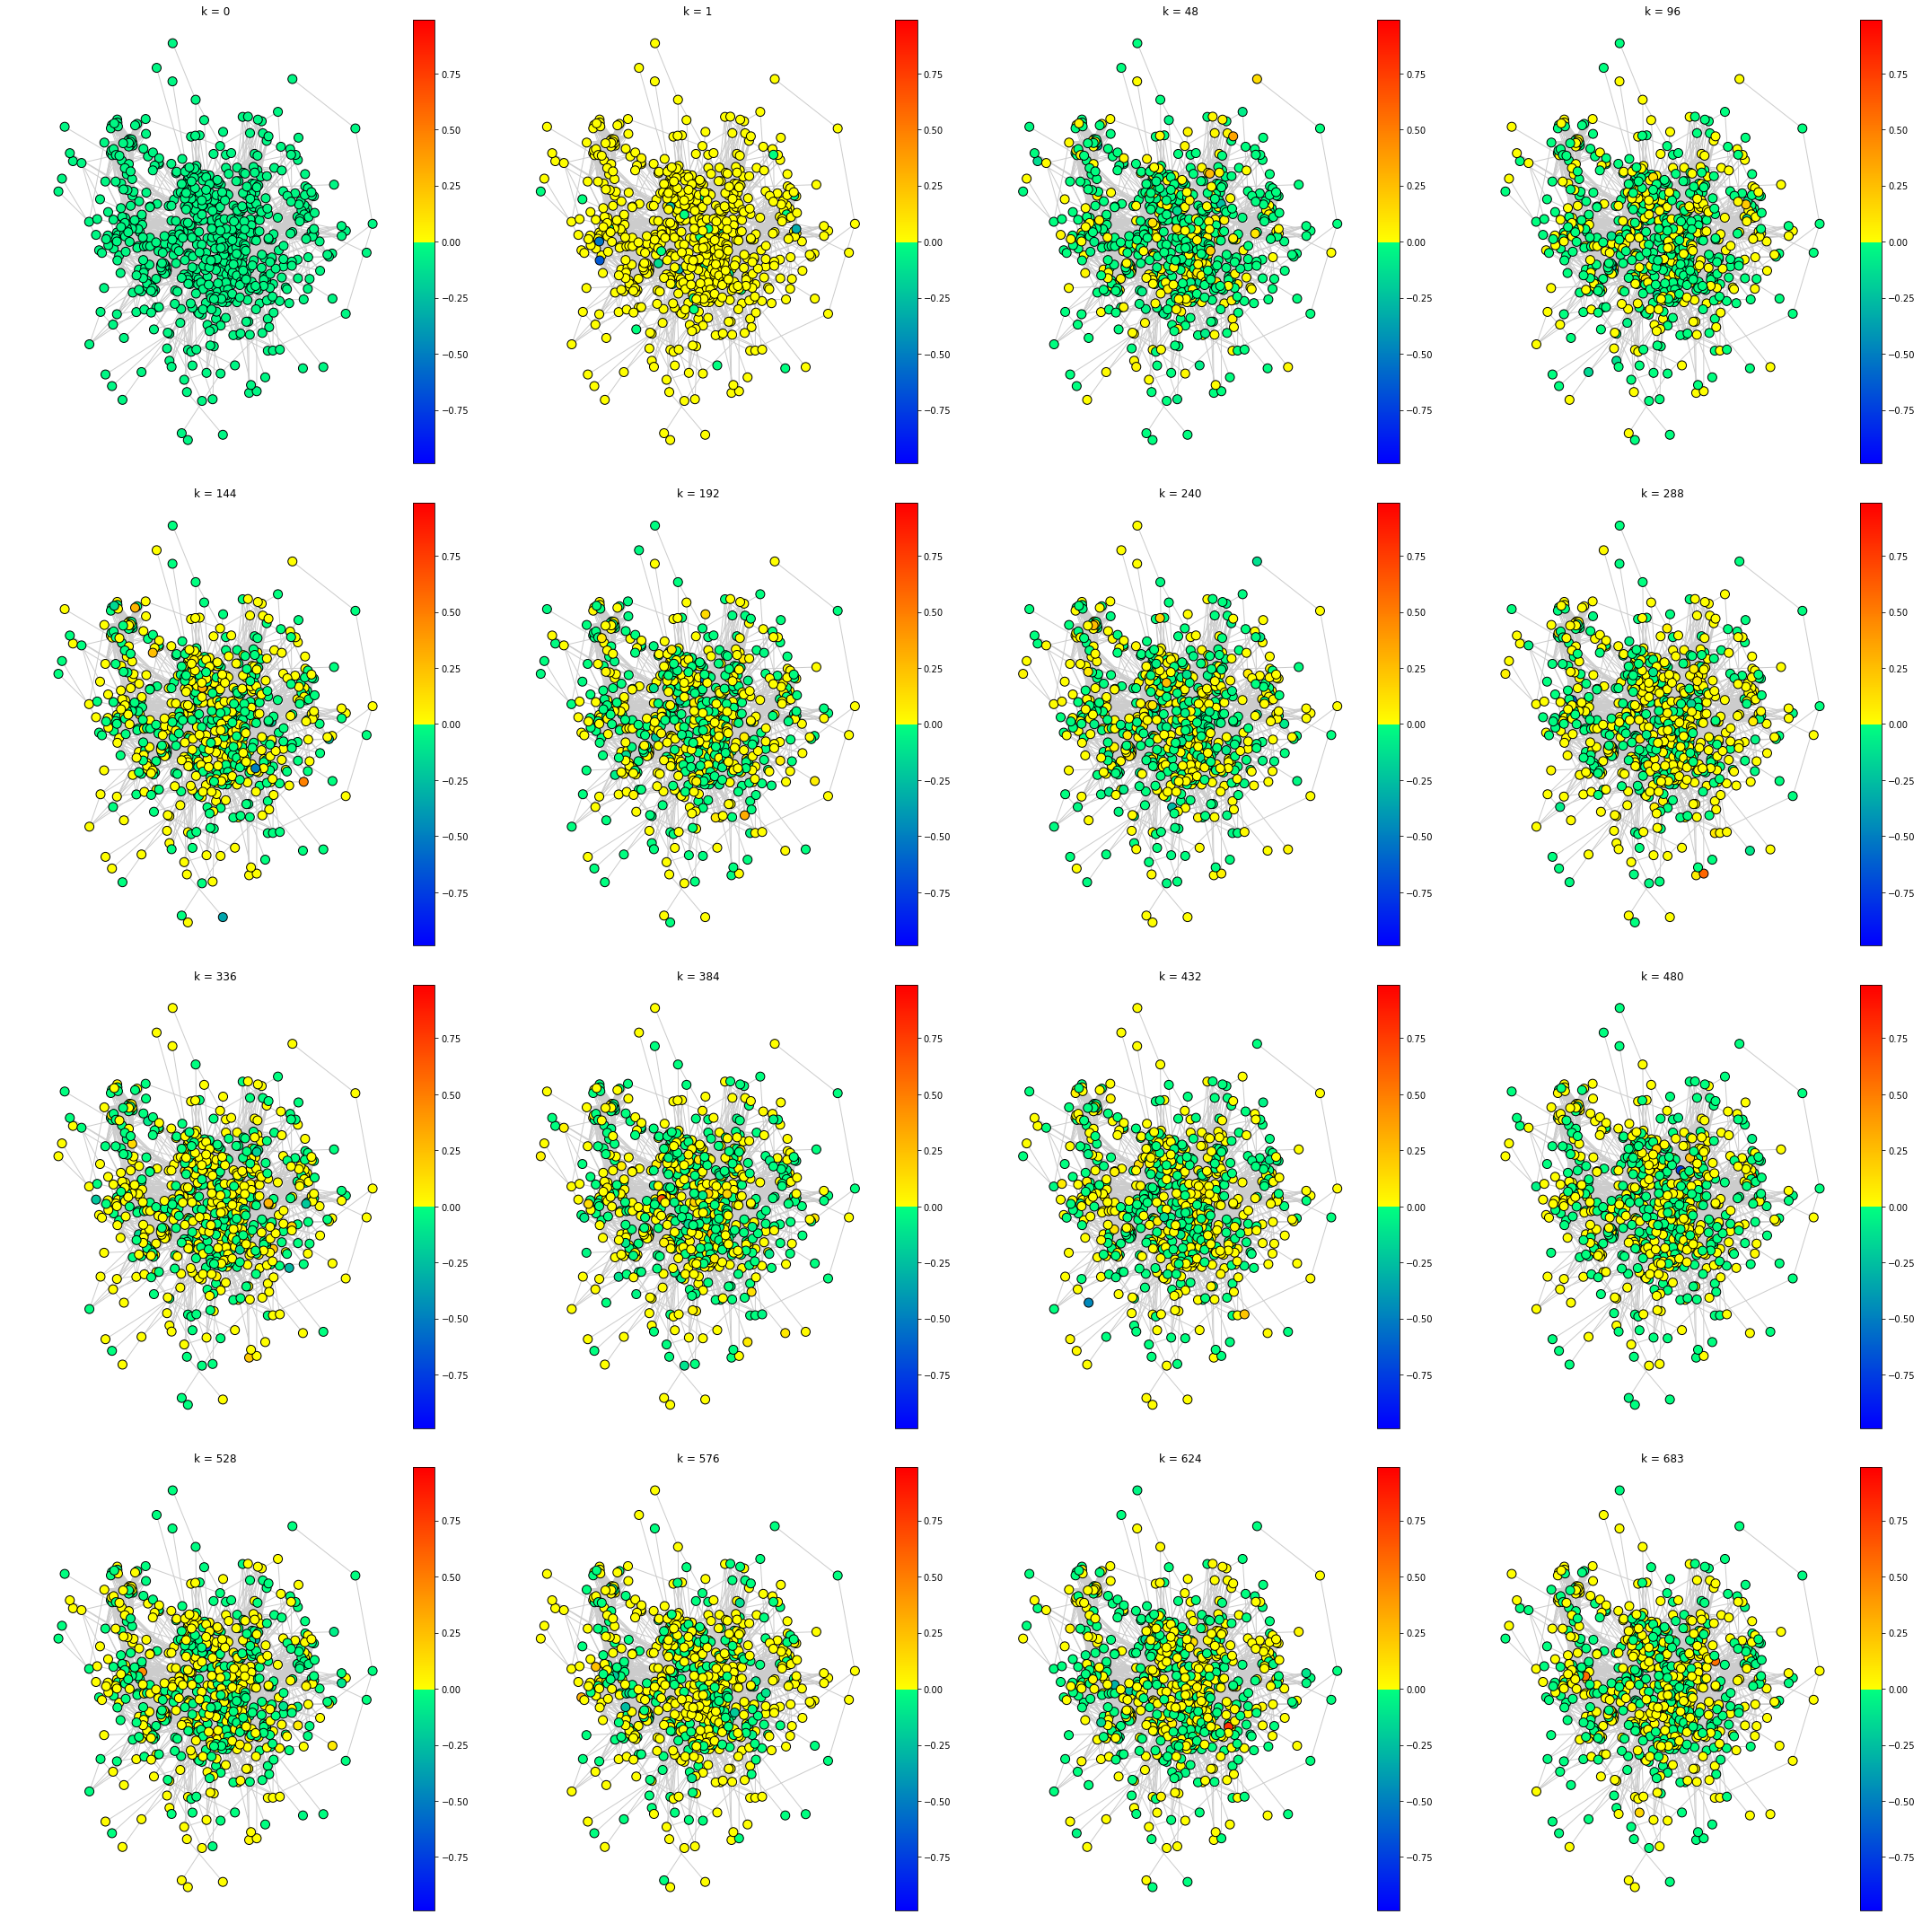

In [33]:
n0 = 4
n_sub = n0 ** 2
base = len(eig[0]) // (n_sub - 2)
k_lst0 = [0, 1]
k_lst1 = [x * base for x in range(1, n_sub-2)]
k_lst2 = [len(eig[0])-1]
k_lst = k_lst0 + k_lst1 + k_lst2
vmin, vmax = change_scale(eig)
for i, k in enumerate(k_lst):
    plt.subplot(n0, n0, i+1)
    draw_sub(k, eig, giant, layout, ccmap, vmin, vmax)
plt.tight_layout()
plt.show()